# Statistical evaluation of generated sequences

In [56]:
#imports
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import log2
from sklearn.preprocessing import MinMaxScaler

ImportError: cannot import name 'sum' from 'math' (/home/fredrik/anaconda3/envs/thesis/lib/python3.10/lib-dynload/math.cpython-310-x86_64-linux-gnu.so)

### Approach to statistical evaluation
The main objective of the statistical evaluation is to quantify how much of the statistical properties of the original data is also present in the synthetic data, i.e how statistically similar/distant are the genuine and synthetic data sets.

To quantify this statistical similarity, Kullback-Leibler (KL) divergence is computed. KL divergence is a method from information theory that compares two probability distribution and say how distant they are from each other. KL = 0 means the distributions are identical and the larger the KL is, the more distant the two distributions are from each other. One thing about KL divergence, is that it's asymmetrical. If a symmetrical measure is wanted, one could use Jensen-Shannon (JS) divergence instead. Where KL divergence highlights how distant two distributions are, JS divergence highlights the similarity. Additionally, JS divergence is symmetric and bounded between 0 and 1. 0 meaning identical and 1 meaning completely different.

Both KL and JS divergence will be computed, to highlight both distance and similarity between the two distributions.

But at the moment we have the sequence of data, and not the distribution. We therefore start by normalizing the data and then find it's histogram, as the histogram also is the discrete probability distribution of the data.

In [77]:
dim = 4
scaler = MinMaxScaler()
ori_df = pd.DataFrame(scaler.fit_transform(np.loadtxt(f'sine_data/sine_123_1000_{dim}.csv', delimiter=',', skiprows=1)))[:200]


with open(os.path.join('synt_data', 'timeGan_generated_sines', f'syn_sine_50000_{dim}_200_290424_10h40.json'), 'r') as file: #Need to change date and time for each sample
    y = json.load(file)
timegan_df = pd.DataFrame(y[0])
var_df = pd.DataFrame(np.loadtxt(f'synt_data/VAR/var_sine_{dim}_200.csv', delimiter=',', skiprows=1))
lstm_df = pd.DataFrame(np.loadtxt(f'synt_data/lstm/lstm_sine_{dim}_196_140524_13h25.csv', delimiter=',', skiprows=1))#Need to change date and time for each sample

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

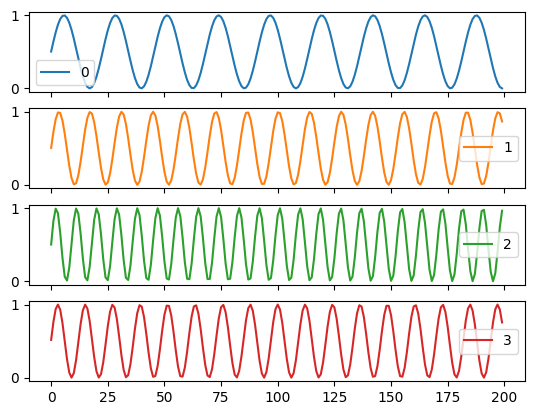

In [78]:
ori_df.plot(subplots=True)

In [79]:
bins = 10

ori_dists = {}
for feat in ori_df.columns:
    feat_dist, bin_edges = np.histogram(ori_df[feat], density=True, bins=bins, range=(0,1))
    x = [round((bin_edges[i-1] + bin_edges[i])/2, 4) for i in range(1, len(bin_edges))]
    feat_dist = feat_dist/np.sum(feat_dist)
    ori_dists[feat] = feat_dist
    # print(x)
    # print(feat_dist)
    # print(f'Sum of estimated distribution is {np.sum(feat_dist)}')
    # plt.plot(x, feat_dist)
    # plt.show()
    

In [80]:
timegan_dists = {}
for feat in timegan_df.columns:
    feat_dist, bin_edges = np.histogram(timegan_df[feat], density=True, bins=bins, range=(0,1))
    x = [round((bin_edges[i-1] + bin_edges[i])/2, 4) for i in range(1, len(bin_edges))]
    feat_dist = feat_dist/np.sum(feat_dist)
    timegan_dists[feat] = feat_dist

var_dists = {}
for feat in var_df.columns:
    feat_dist, bin_edges = np.histogram(var_df[feat], density=True, bins=bins, range=(0,1))
    x = [round((bin_edges[i-1] + bin_edges[i])/2, 4) for i in range(1, len(bin_edges))]
    feat_dist = feat_dist/np.sum(feat_dist)
    var_dists[feat] = feat_dist

lstm_dists = {}
for feat in lstm_df.columns:
    feat_dist, bin_edges = np.histogram(lstm_df[feat], density=True, bins=bins, range=(0,1))
    x = [round((bin_edges[i-1] + bin_edges[i])/2, 4) for i in range(1, len(bin_edges))]
    feat_dist = feat_dist/np.sum(feat_dist)
    lstm_dists[feat] = feat_dist


In [87]:

# calculate the kl divergence
def kl_div(p, q):
    # print(p[0], q[0])
    return np.sum([p[i] * np.log2(p[i]/q[i]) for i in range(len(p))])

def dists_kl_div(test_dists, ori_dists):
    KLs = []
    for key, value in test_dists.items():
        # print(value, ori_dists[key])
        KLs.append(kl_div(value, ori_dists[key]))
    return KLs


In [88]:
timegan_kl = dists_kl_div(timegan_dists, ori_dists)
var_kl = dists_kl_div(var_dists, ori_dists)
lstm_kl = dists_kl_div(lstm_dists, ori_dists)

[0.005557200065197918, 0.007734765956265646, 0.09486294260604211, 0.010761295486942001]
[0.003155303741411486, 0.002866283237828648, 0.006055377518359039, 0.003762095130957755]
[0.015719248028610154, 0.015171083210169682, 0.13448358561269866, 0.013052362506444225]


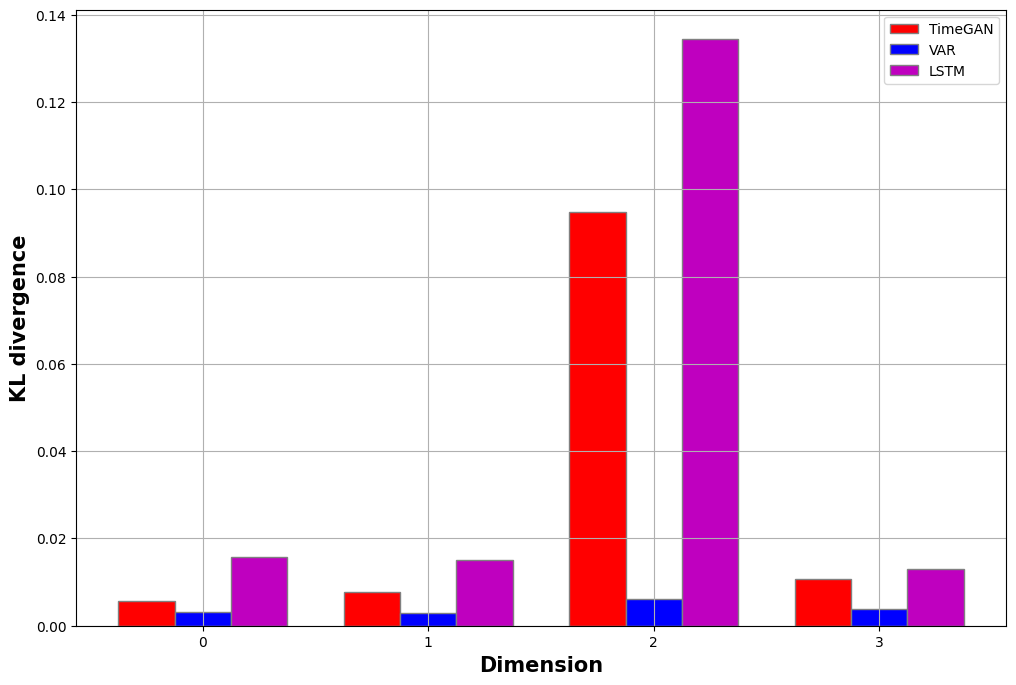

In [92]:
barWidth = 1/4
fig = plt.subplots(figsize =(12, 8)) 

# Set position of bar on X axis 
br1 = np.arange(len(timegan_kl)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
br4 = [x + barWidth for x in br3] 

# Make the plot
plt.bar(br1, timegan_kl, color ='r', width = barWidth, 
        edgecolor ='grey', label ='TimeGAN') 
plt.bar(br2, var_kl, color ='b', width = barWidth, 
        edgecolor ='grey', label ='VAR') 
plt.bar(br3,  lstm_kl, color ='m', width = barWidth, 
        edgecolor ='grey', label ='LSTM') 


# Adding Xticks 
plt.xlabel('Dimension', fontweight ='bold', fontsize = 15) 
plt.ylabel('KL divergence', fontweight ='bold', fontsize = 15) 
plt.xticks([r + 1*barWidth for r in range(4)], 
        ['0','1', '2', '3'])
 
plt.legend()
plt.grid()
plt.show() 